# Multi-Layer Perceptron Neural Network

**Due: Wednesday, 11/22/2023, 2:15 PM**

Welcome to your fourth assignment. You will build a multi-layer perceptron neural network in this assignment. The goal of building such a  is to classify hand-written digits.

## Exercises:
1. $\color{violet}{\textbf{(20\%) Data Preprocessing}}$
2. $\color{violet}{\textbf{(5\%) Logistic Regression Model}}$
3. $\color{violet}{\textbf{(5\%) Cross Entropy Loss}}$
4. $\color{violet}{\textbf{(40\%) Gradient Descent Optimization}}$
5. $\color{violet}{\textbf{(15\%) Evaluation on Test Dataset}}$
6. $\color{violet}{\textbf{(15\%) Test Model with New Image}}$

## Instructions:
- Write your code only between the $\color{green}{\textbf{\small \#\#\# START CODE HERE \#\#\#}}$ and $\color{green}{\textbf{\small \#\#\# END CODE HERE \#\#\#}}$ commented lines. $\color{red}{\textbf{Do not modify code out of the designated area.}}$
- Reference answers are provided after a certain coding blocks. Be aware if your answer is different from the reference..
- **Need to install [Torchvision](https://pytorch.org/vision/stable/index.html)**
    ```console
    pip install torchvision
    ```
**You will learn:**
- Usage of Rectified Linear Unit (ReLU) activation function.
- Generalize number and dimension of the hidden layers.



## Review

**NOTE: math representations of forward and backward propogation has been updated. Please use the equations in the [updated slides](https://linzhanguca.github.io/_docs/applied_deep_learning-2022/0921/nn_p2.pdf) or the follows if you prefer no transopose in the forward propagation.**

To build your neural network, you will complete several "helper functions". These helper functions will be used to realize the forward and backward propagation when training a K-layer neural network. Each small helper function you will implement will have detailed instructions that will walk you through the necessary steps. Here is an outline of this assignment, you will:

- Initialize the parameters for K-layer neural network.
- Implement the forward propagation. 
     - Compute linear transformation $\mathbf{Z}^{[k]} = \mathbf{X}^{[k-1]} \cdot \mathbf{W}^{[k]} + \mathbf{b}^{[k]}$.
     - Compute activation: $X^{[k]} = g(\mathbf{Z}^{[k]})$.
     - Stack the "linear transfortmation" and "activation" to compute predictions in the final layer.
- Compute the cross entropy loss: 
    $$\mathcal{L(\hat{\mathbf{y}}, \mathbf{y}) = \frac{1}{M}\sum_{i=1}^M (-\mathbf{y}log(\hat{\mathbf{y}}) - (1 - \mathbf{y})log(1 - \hat{\mathbf{y}}))}$$
- Compute gradients of the parameters for backward propagation.
    $$d\mathbf{Z}^{[k]} = \frac{\partial{J}}{\partial{\mathbf{Z}^{[k]}}} = d\mathbf{X}^{[k]} * g'^{[k]}(\mathbf{Z}^{[k]})$$
    $$d\mathbf{W}^{[k]} = \frac{\partial{J}}{\partial{\mathbf{W}^{[k]}}} = \frac{1}{M}\mathbf{X}^{[k-1]\mathbf{T}} \cdot d\mathbf{Z}^{[k]}$$
    $$d\mathbf{b}^{[k]} = \frac{\partial{J}}{\partial{\mathbf{b}^{[k]}}} = \frac{1}{M} \Sigma d\mathbf{Z}^{[k]}$$
    $$d\mathbf{X}^{[k-1]} = \frac{\partial{J}}{\partial{\mathbf{X}^{[k-1]}}} = d\mathbf{Z}^{[k]} \cdot \mathbf{W}^{[k]\mathbf{T}}$$
- Update the parameters using gradient descent algorithm.

## 1. Load Dataset
Torchvision provides a descent pool of datasets. We'll load one of the built-in dataset, [FashionMNIST](https://pytorch.org/vision/stable/datasets.html) to investigate multi-class classification using a generic Multi-Layer Perceptron (MLP) model.

training feature array shape: (60000, 28, 28), test feature array shape: (10000, 28, 28)
training target array shape: (60000,), test target array shape: (10000,)
{'T-shirt/top': 0, 'Trouser': 1, 'Pullover': 2, 'Dress': 3, 'Coat': 4, 'Sandal': 5, 'Shirt': 6, 'Sneaker': 7, 'Bag': 8, 'Ankle boot': 9}


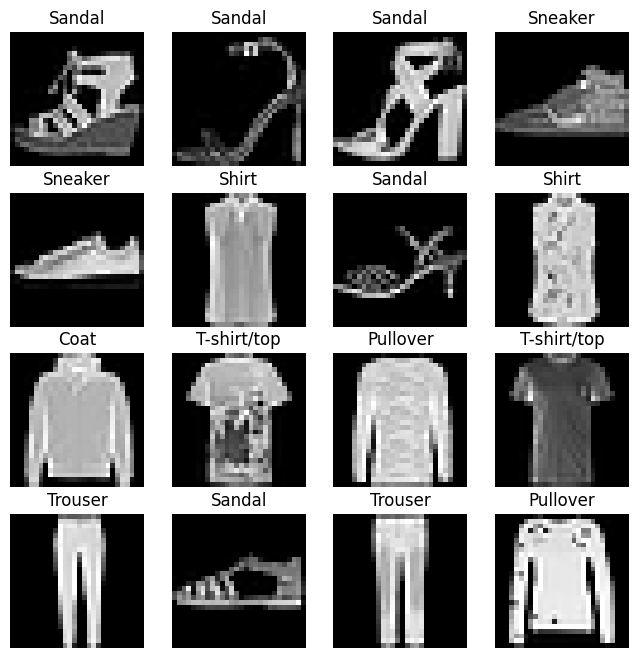

In [1]:
from torchvision import datasets
import matplotlib.pyplot as plt
import numpy as np

# Load dataset
train_set = datasets.FashionMNIST('./data', train=True, download=True)
test_set = datasets.FashionMNIST('./data', train=False, download=True)

# Extract important arrays
train_feature_array = train_set.data.numpy()
train_target_array = train_set.targets.numpy()
test_feature_array = test_set.data.numpy()
test_target_array = test_set.targets.numpy()
category_keys = train_set.classes
category_vals = range(len(category_keys))
category_dict = dict((map(lambda i,j : (i,j), category_keys, category_vals)))

print(f"training feature array shape: {train_feature_array.shape}, test feature array shape: {test_feature_array.shape}")
print(f"training target array shape: {train_target_array.shape}, test target array shape: {test_target_array.shape}")
print(category_dict)

# Visualize
figure = plt.figure(figsize=(8, 8))
cols, rows = 4, 4
for i in range(1, cols * rows + 1):
    sample_idx = np.random.randint(0, len(train_set))
    img, label = train_set[sample_idx]
    figure.add_subplot(rows, cols, i)
    plt.title(category_keys[label])
    plt.axis("off")
    plt.imshow(img, cmap="gray")


## 2. Preprocess the Data
A $\mathcal{C}$-calss dataset with   is made up with a feature matrix: $\mathbf{X} = [^{(1)}\mathbf{x}, ^{(2)}\mathbf{x}, ..., ^{(M)}\mathbf{x}]^T$. and a one-hot encoded target matrix $\mathbf{Y} = [^{(1)}\mathbf{y}, ^{(2)}\mathbf{y}, ..., ^{(M)}\mathbf{y}]^T$. Where $M$ is the total number of instances in the dataset, $^{(m)}\mathbf{x} = [^{(m)}x_1, ..., ^{(m)}x_n]$ is a normalized and flattened row vector bears $n$ feature values, and $^{(m)}\mathbf{y} = [0, ..., 0, 1, 0, ..., 0]$ is a one-hot encoded row vector.

- A grey-scale image can be represented by a **2-dimensional array with shape $(width, height)$**. Where, $width$ indicates number of pixels on horizontal direction, $height$ indicates number of pixels on vertical direction.
- We can use an **integer ranged 0~255** to describe a pixel's color intensity. However, it is easier for your computer to handlle float values.
- We would like to convert an image array into a row vector, or a **2d array with shape $(1, width*height)$**. So that, we can stack these row vectors vertically to form a feature matrix.
- We also would like to encode target array into one-hot format.


We will access the raw data by extracting it from the dataloaders. Then, process and prepare the raw data so that it can be used in later steps.

### $\color{violet}{\textbf{(20\%) Exercise 1: Data Preprocessing}}$
1. Reshape feature array.
2. One-hot encode target array
3. Rescale feature arrary, represent each pixel with a float numbers in range 0~1. 

In [2]:
### START CODE HERE ### (≈ 10 lines of code)
M_train = train_target_array.shape[0]  # number of sampels in training data
M_test = test_target_array.shape[0]  # number of samples in test data
# Reshape feature and target arrays
flatten_feature_train = train_feature_array.reshape(M_train, -1)  # (60000, 28, 28) -> (60000, 1)
flatten_feature_test = test_feature_array.reshape(M_test, -1)  # (10000, 28, 28) -> (10000, 1)
# One hot encode targets
onehot_target_train = np.zeros((M_train, len(category_dict)))
onehot_target_train[np.arange(M_train), train_target_array] = 1
onehot_target_test = np.zeros((M_test, len(category_dict)))
onehot_target_test[np.arange(M_test), test_target_array] = 1
# print(np.sum(onehot_target_test, axis=0))
# Rescale features
rescale_feature_train = flatten_feature_train / 255
rescale_feature_test = flatten_feature_test / 255
### END CODE HERE ###

# Rename
feature_train = rescale_feature_train
feature_test = rescale_feature_test
target_train = onehot_target_train
target_test = onehot_target_test
print(f"training feature shape: {feature_train.shape}, test feature shape: {feature_test.shape}, training target shape: {target_train.shape}, test target shape: {target_test.shape}")
print(f"sample feature portion: \n{feature_train[3321][350:400]}")
print(f"sample target: \n{target_train[3321]}")


training feature shape: (60000, 784), test feature shape: (10000, 784), training target shape: (60000, 10), test target shape: (10000, 10)
sample feature portion: 
[0.99607843 0.79215686 0.82745098 0.79215686 0.79607843 0.79215686
 0.83921569 0.84313725 0.83921569 0.84705882 0.82352941 0.92941176
 0.57254902 0.         0.00392157 0.         0.         0.
 0.         0.         0.00784314 0.01568627 0.01176471 0.
 0.         0.         0.38039216 0.98823529 0.80784314 0.83529412
 0.80392157 0.81176471 0.8        0.80784314 0.83529412 0.83921569
 0.84313725 0.84705882 0.85490196 0.90980392 0.77254902 0.
 0.         0.00784314 0.01960784 0.02745098 0.00784314 0.00392157
 0.         0.        ]
sample target: 
[0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]


**Expected Output**:
>
```console
training feature shape: (60000, 784), test feature shape: (10000, 784), training target shape: (60000, 10), test target shape: (10000, 10)
sample feature portion: 
[0.99607843 0.79215686 0.82745098 0.79215686 0.79607843 0.79215686
 0.83921569 0.84313725 0.83921569 0.84705882 0.82352941 0.92941176
 0.57254902 0.         0.00392157 0.         0.         0.
 0.         0.         0.00784314 0.01568627 0.01176471 0.
 0.         0.         0.38039216 0.98823529 0.80784314 0.83529412
 0.80392157 0.81176471 0.8        0.80784314 0.83529412 0.83921569
 0.84313725 0.84705882 0.85490196 0.90980392 0.77254902 0.
 0.         0.00784314 0.01960784 0.02745098 0.00784314 0.00392157
 0.         0.        ]
sample target: 
[0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
```

## 2. Forward Pass
A Multi-Layer Perceptron (MLP) model is featured with multiple layers of transformed features. Any two adjacent layer are connected by a linear model and an activation function. The linear model is governed by a set of weight parameters and a set of bias parameters. The general structure of an MLP model is shown below.
![](./nnNNN.png)

### 2.1. Initialize Parameters
A linear model governed by weights $\mathbf{W}^{[l]}$ and $\mathbf{b}^{[l]}$ transforms features, $\mathbf{X}^{[l-1]}$ in the $l-1$-th layer to $\mathbf{Z}^{[l]}$ in the $l$-th layer.

$\mathbf{Z}^{[l]} = \mathbf{X}^{[l-1]} \cdot \mathbf{W}^{[l]T} + \mathbf{b}^{[l]}$

Assume $\mathbf{X}^{[l-1]}$ has $N_{l-1}$ features and $\mathbf{X}^{[l]}$ has $N_{l}$ features, then $\mathbf{W}^{[l]}$ is with shape $(N_l, N_{l-1})$, $\mathbf{b}^{[l]}$ is with shape $(1, N_l)$

### $\color{violet}{\textbf{(10\%) Exercise 2: Parameter Initialization}}$
Define a function to initialize weights and biases parameters and save these parameters in a **dictionary**. 
- Input sizes of all the layers (**include the input layer**) using a **list**.
- Use a **`for` loop** to randomly initialize $\mathbf{W}^{[l]}$ and $\mathbf{b}^{[l]}$ for the $l$-th layer.


In [5]:
def init_params(layer_sizes):
    """ Parameter initialization function
    Args:
        layer_sizes -- list/tuple, (input size, ..., hidden layer size, ..., output size)
    Returns:
        parameters -- dictionary, contains parameters: Wi and bi, i is the i-th layer
    """
    parameters = {}
    ### START CODE HERE ### (≈ 2 lines of code)
    for i in range(len(layer_sizes) - 1):
        parameters['W'+str(i+1)] = np.random.normal(0, 0.0001, size=(layer_sizes[i+1], layer_sizes[i]))
        parameters['b'+str(i+1)] = np.random.normal(0, 0.0001, size=(1, layer_sizes[i+1]))
    ### END CODE HERE ###

    return parameters

# Sanity check
np.random.seed(3321)
dummy_layer_sizes = (6, 5, 4, 3)  # (input size, layer1 size, layer2 size, output size)
dummy_params = init_params(dummy_layer_sizes)
print(dummy_params.keys())
print(dummy_params)


dict_keys(['W1', 'b1', 'W2', 'b2', 'W3', 'b3'])
{'W1': array([[ 3.68455981e-05, -1.38782645e-04, -7.23142013e-05,
         9.20641119e-05, -1.95355264e-05,  3.87255258e-05],
       [-6.00629078e-05,  3.25435259e-06,  6.46665063e-05,
        -7.84748031e-05,  1.41884652e-04, -6.15479349e-05],
       [-1.10127440e-04, -6.82385574e-05,  7.96622349e-05,
         5.25934678e-05, -1.78411966e-04,  1.28629057e-04],
       [ 5.66879246e-05,  8.95999019e-05, -1.62874713e-05,
         3.51109174e-05, -1.03338181e-04, -8.88623865e-05],
       [ 5.10860443e-05,  1.19661547e-04,  8.64757553e-05,
        -1.41101724e-04,  1.38003186e-04, -1.06812125e-04]]), 'b1': array([[ 6.38004843e-05, -6.19666755e-05,  1.12931166e-04,
        -3.12290798e-05,  5.59708416e-05]]), 'W2': array([[ 1.02685210e-04, -1.28307992e-04, -4.03018811e-05,
        -4.09270011e-05, -1.84834135e-05],
       [ 1.71466862e-04, -9.69611346e-05,  4.40873689e-05,
        -1.10516782e-04, -5.17959570e-05],
       [-1.87055902e-04, -6.

**Expected Output**:
>
```console
dict_keys(['W1', 'b1', 'W2', 'b2', 'W3', 'b3'])
{'W1': array([[ 3.68455981e-05, -1.38782645e-04, -7.23142013e-05,
         9.20641119e-05, -1.95355264e-05,  3.87255258e-05],
       [-6.00629078e-05,  3.25435259e-06,  6.46665063e-05,
        -7.84748031e-05,  1.41884652e-04, -6.15479349e-05],
       [-1.10127440e-04, -6.82385574e-05,  7.96622349e-05,
         5.25934678e-05, -1.78411966e-04,  1.28629057e-04],
       [ 5.66879246e-05,  8.95999019e-05, -1.62874713e-05,
         3.51109174e-05, -1.03338181e-04, -8.88623865e-05],
       [ 5.10860443e-05,  1.19661547e-04,  8.64757553e-05,
        -1.41101724e-04,  1.38003186e-04, -1.06812125e-04]]), 'b1': array([[ 6.38004843e-05, -6.19666755e-05,  1.12931166e-04,
        -3.12290798e-05,  5.59708416e-05]]), 'W2': array([[ 1.02685210e-04, -1.28307992e-04, -4.03018811e-05,
        -4.09270011e-05, -1.84834135e-05],
       [ 1.71466862e-04, -9.69611346e-05,  4.40873689e-05,
        -1.10516782e-04, -5.17959570e-05],
       [-1.87055902e-04, -6.31341925e-05, -5.47992268e-05,
         3.67804566e-05, -1.05795654e-04],
       [ 1.24964681e-04,  3.60854003e-05,  1.30113815e-04,
         1.01177937e-04,  2.22286230e-05]]), 'b2': array([[ 1.16709537e-04, -1.12496462e-04, -9.47925077e-05,
        -4.49789001e-05]]), 'W3': array([[ 1.01049508e-04, -3.52965408e-05,  2.06672986e-04,
        -1.67359842e-05],
       [-7.34788781e-05,  1.28189925e-05,  3.67334763e-05,
        -3.00482492e-05],
       [ 9.36343566e-05, -3.80351405e-05,  6.59823461e-06,
         5.61206851e-05]]), 'b3': array([[ 2.57409859e-04,  1.69968799e-05, -7.22321090e-05]])}
```

### 2.2 - Forward Propagation
A linear model transforms features, $\mathbf{X}^{[l-1]}$ in the $l-1$-th layer to $\mathbf{Z}^{[l]}$ in the $l$-th layer. Then we apply a Linear Rectified Unit (ReLU) function on $\mathbf{Z}^{[l]}$ to form new features $\mathbf{Z}^{[l]}$ in the $l$-th layer.

$\mathbf{Z}^{[l]} = \mathbf{X}^{[l-1]} \cdot \mathbf{W}^{[l]T} + \mathbf{b}^{[l]}$

$\mathbf{X}^{[l]} = ReLU(\mathbf{Z}^{[l]})$

The last layer needs to be activcated by a softmax function.

#### $\hat{y}_i = \frac{e^{z^{[L]}_i}}{\sum^C_{i=1} e^{z^{[L]}_i}}$, where $C$ is the total number of the classes.
The maxtrix $\mathbf{Z}^{[L]}$ has shape: $(M, C)$, where $M$ is the number of samples. When applying softmax activation, we only want to apply it on the 2nd dimension (1st axis in numpy). So that each row in $\mathbf{Z}^{[L]}$ will be converted to probabilities.
### $\color{violet}{\textbf{(40\%) Exercise 3: Linear Model and Activation}}$
- Define ReLU activation function and softmax activation function.
- Define linear model.
- Define forward propagation process.


In [11]:
### START CODE HERE ### (≈ 2 lines of code)
def relu(x):
    """ Rectified linear unit function
    Args:
        x -- scalar/array
    Returns:
        y -- scalar/array, 0 if x <= 0, x if x >0
    """
    y = np.maximum(0, x)

    return y

def softmax(x):
    """ Softmax function
    Args:
        x -- array
    Returns:
        prob -- array
    """
    prob = np.exp(x) / np.sum(np.exp(x), axis=-1, keepdims=True)
    
    return prob

def linear(feature, weight, bias):
    """ Linear model
    Args:
        feature (matrix): 2d array with shape (M, N^[l-1])
        weight (matrix): 2d array with shape (N^[l], N^[l-1])
        bias (row vector): 2d array with shape (1, N^[l])
    Returns:
        Z (matrix): 2d array with shape (M, , N^[l])
    """
    Z = np.dot(feature, weight.T) + bias
        
    return Z

def forward(input_feature, params):
    """ Forward propagation process
    Args:
        input_feature (matrix): 2d array with shape (M, N^[0])
        params: dictionary
    Returns:
        prediction: 2d array with shape (M, C)
        cache: dictionary, stores intemediate Xs and Zs.
    """
    cache = {'X0': input_feature}
    for i in range(int(len(params) / 2) - 1):
        cache['Z' + str(i+1)] = linear(cache['X' + str(i)], params['W' + str(i+1)], params['b' + str(i+1)])
        cache['X' + str(i+1)] = relu(cache['Z' + str(i+1)])
    cache['Z' + str(i+2)] = linear(cache['X' + str(i+1)], params['W' + str(i+2)], params['b' + str(i+2)])
    prediction = softmax(cache['Z' + str(i+2)])

    return prediction, cache

# Sanity check
np.random.seed(3321)
dummy_input = np.random.randn(8,6)
dummy_pred, dummy_cache = forward(dummy_input, dummy_params)
print(dummy_pred)
print(f"cache dictionary keys: {dummy_cache.keys()}")

[[0.33339668 0.33331653 0.33328679]
 [0.33339668 0.33331653 0.33328679]
 [0.33339668 0.33331653 0.33328679]
 [0.33339668 0.33331653 0.33328679]
 [0.33339668 0.33331653 0.33328679]
 [0.33339668 0.33331653 0.33328679]
 [0.33339668 0.33331653 0.33328679]
 [0.33339668 0.33331653 0.33328679]]
cache dictionary keys: dict_keys(['X0', 'Z1', 'X1', 'Z2', 'X2', 'Z3'])


**Expected Output**:
>
```console
[[0.33339668 0.33331653 0.33328679]
 [0.33339668 0.33331653 0.33328679]
 [0.33339668 0.33331653 0.33328679]
 [0.33339668 0.33331653 0.33328679]
 [0.33339668 0.33331653 0.33328679]
 [0.33339668 0.33331653 0.33328679]
 [0.33339668 0.33331653 0.33328679]
 [0.33339668 0.33331653 0.33328679]]
cache dictionary keys: dict_keys(['X0', 'Z1', 'X1', 'Z2', 'X2', 'Z3'])
```

### 2.2 - Linear Transformation
Use the following equation to perform linear transformation:
$$\mathbf{Z}^{[k]} = \mathbf{X}^{[k-1]} \cdot \mathbf{W}^{[k]} + \mathbf{b}^{[k]}$$

#### **(5%) Exercise 2.2**: Linear transformation.
Complete `linear()` function to transoform the features in the previous layer (`X_j`) into the non-activated features in the next layer (`Z_k`) using parameters: `W_k` and `b_k`.

In [ ]:
def linear(X_j, W_k, b_k):
    """
    linear transformation converts neurons in previous layer to neuron in current layer.

    Arguments:
        X_j -- numpy array, feature matrix of the (k-1)th layer. shape: (number_of_examples, previous_layer_dimension)
        W_k -- numpy array, weights matrix connects (k-1)th layer to kth layer. shape: (previous_layer_dimension, current_layer_dimension)
        b_k -- numpy array, bias vector connects (k-1)th layer to kth layer. shape: (1, current_layer_dimension)

    Returns:
        Z_k -- numpy array, linear transformed (pre-activation) featues matrix. shape: (number_of_examples, current_layer_dimension ) 
        cache -- dictionary {'X_j', 'W_k', 'b_k', 'Z_k'}, useful intermediate results for later usage.
    """

    ### START CODE HERE ###
    Z_k = np.dot(X_j, W_k) + b_k
    ### END CODE HERE ###
    
    assert Z_k.shape == (X_j.shape[0], W_k.shape[1])
    cache = {
        'X_j': X_j,
        'W_k': W_k,
        'b_k': b_k,
        'Z_k': Z_k,
    }

    return Z_k, cache

# test
np.random.seed(4350)
X = np.random.randn(3, 4)
W = np.random.randn(4, 2)
b = np.random.randn(1, 2)
Z, cache = linear(X, W, b)
print(f"pre-activation features: {Z}")
print(f"linear cache: {cache}")

**Expected output**:

```console
pre-activation features: [[-0.5691033   2.86655348]
 [ 1.50009864  1.85049448]
 [ 0.69190761 -2.80338728]]
linear cache: {'X_j': array([[-0.97866006,  0.05901167, -1.42715059, -0.27632879],
       [-0.45200202, -0.64213329,  0.22489383,  0.10720757],
       [-0.66929759, -0.05123023,  2.44058435, -0.88938706]]), 'W_k': array([[ 0.03347135, -0.49223651],
       [-1.51707154, -0.9012758 ],
       [ 0.40908305, -1.20410713],
       [ 0.81364786,  1.56567891]]), 'b_k': array([[0.36183616, 1.15220702]]), 'Z_k': array([[-0.5691033 ,  2.86655348],
       [ 1.50009864,  1.85049448],
       [ 0.69190761, -2.80338728]])}
```

### 2.3 - Activation Functions
Activation functions add non-linear transformations toward the features. 
- Sigmoid
$$y = \sigma(x) = \frac{1}{1+e^{-x}}$$
- Hyperbolic Tangent
$$y = tanh(x) = \frac{e^x - e^{-x}}{e^x+e^{-x}}$$
- Rectified Linear Unit
$$y = ReLU(x) = 
    \begin{cases}
        0   & x \leq 0 \\
        x   & x > 0
    \end{cases}
$$

Linearly transformed features will be non-linearly activated by:
$$X^{[k]} = g(\mathbf{Z}^{[k]})$$
All the activation functions are either pre-built in `utils.py` or included in NumPy library, you don't have to do anything in this step. However, you can run the following code block to observe how different activation functions affect the features.


In [ ]:
np.random.seed(4350)
Z = np.random.randn(1,4)
print(f"\noriginal feature: {Z}, \nsigmoid activated feature: {sigmoid(Z)} \ntanh activated feature: {np.tanh(Z)} \nrelu activated feature: {relu(Z)}")

### 2.4 - Stack Linear and Activation 
Now, you can stack linear transformations and activations to implement any layer neural network's forward propagation.

#### **(20%) Exercise 2.4: Forward propagation**
Complete `forward()` function to implement the $K$-layer Neural Network. You will need to perform `linear()` then use any activation functions $K-1$ times, then follows the last `linear()` transformation followed by the `sigmoid()` activation.
You'll get a column vector, `yhat` with shape: `(number of example, 1)` in the end. 

> Tips:
- > Use the functions you had previously written 
- > Use a for loop to repeat `z=linear(x) -> x=relu(z)` or `z=linear(x) -> x=np.tanh(z)` or `z=linear(x) -> x=sigmoid(z)` (K-1) times
- > Don't forget to keep track of the intermediate results in each layer. You can use a nested dictionary: `caches` to store `cache` from each layer.

In [ ]:
def forward(inputs, params, activation='relu'):
    """
    forward function loops linear and activation to tranform the original features into the probability of the predictions.

    Arguments:
        inputs -- numpy array, original feature matrix. shape: (number_of_examples, original_feature_dimension)
        params -- dictionary, stores weights and biases connects (k-1)th layer to kth layer.
        activation -- string, activation type for the hidden layers (exclude the final layer).

    Returns:
        yhat -- numpy array, column vector of the predicted probability of the classes. shape: (number_of_examples, 1) 
        caches -- nested dictionary {'layer1: {cache}', ... , 'layerK': {cache}}, stores all the intermediate results in each layer.
    """

    caches = {}
    num_layers = len(params) // 2

    ### START CODE HERE ###
    for k in range(1, num_layers):
        Z_k, cache = None
        if activation=='relu':
            X_k = None
        elif activation=='tanh':
            X_k = None
        elif activation=='sigmoid':
            X_k = None
        else:
            X_k = Z_k
        caches['layer' + str(k)] = cache

    Z_K, cache = None # final layer linear transform
    yhat = None  # final layer activation 
    caches['layer' + str(num_layers)] = cache
    ### END CODE HERE ###
    
    assert yhat.shape == (inputs.shape[0], 1)

    return yhat, caches



# Test forward()
X = np.array([
        [-0.31178367, 0.72900392, 0.21782079, -0.8990918],
        [-2.48678065, 0.91325152, 1.12706373, -1.51409323],
        [1.63929108, -0.4298936, 2.63128056, 0.60182225],
        [-0.33588161, 1.23773784, 0.11112817, 0.12915125],
        [0.07612761, -0.15512816, 0.63422534, 0.810655],
    ]).T
parameters = {
    'W1': np.array([
        [0.35480861, 1.81259031, -1.3564758, -0.46363197, 0.82465384],
        [-1.17643148, 1.56448966, 0.71270509, -0.1810066, 0.53419953],
        [-0.58661296, -1.48185327, 0.85724762, 0.94309899, 0.11444143],
        [-0.02195668, -2.12714455, -0.83440747, -0.46550831, 0.23371059]
    ]).T,
    'b1': np.array([[1.38503523, -0.51962709, -0.78015214, 0.95560959]]),
    'W2': np.array([
        [-0.12673638, -1.36861282, 1.21848065, -0.85750144],
        [-0.56147088, -1.0335199, 0.35877096, 1.07368134],
        [-0.37550472, 0.39636757, -0.47144628, 2.33660781]
    ]).T,
    'b2': np.array([[1.50278553, -0.59545972, 0.52834106]]),
    'W3': np.array([[0.9398248, 0.42628539, -0.75815703]]).T,
    'b3': np.array([[-0.16236698]])}
y, caches = forward(X, parameters)
print(f"preds = {y}")
print(f"layer2 cache = {caches['layer2']}")

**Expected output:**
```console
preds = [[0.03921668]
 [0.70498921]
 [0.19734387]
 [0.04728177]]
layer2 cache = {'X_j': array([[0.        , 0.        , 4.18500916, 5.05850802],
       [3.18040135, 0.        , 0.        , 0.        ],
       [0.4074501 , 3.18141622, 0.        , 0.        ],
       [0.        , 0.        , 2.72141639, 3.82321852]]), 'W_k': array([[-0.12673638, -0.56147088, -0.37550472],
       [-1.36861282, -1.0335199 ,  0.39636757],
       [ 1.21848065,  0.35877096, -0.47144628],
       [-0.85750144,  1.07368134,  2.33660781]]), 'b_k': array([[ 1.50278553, -0.59545972,  0.52834106]]), 'Z_k': array([[ 2.2644603 ,  6.3372257 , 10.3750834 ],
       [ 1.09971298, -2.38116247, -0.66591466],
       [-2.90298025, -4.11228806,  1.63635184],
       [ 1.54036335,  4.48582383,  8.17870168]])}
```

### 2.5 - Loss Function

In modern deep learning community, cost and loss is used interchangebly. People no longer distinguish the example-wise loss and the total cost. It is convention that using loss function to represent the cost function we were using. You can use `loss_fn()` which is given below to compute the cross entropy loss and monitor the training procedure later. 

In [ ]:
def loss_fn(preds, labels):
    loss = np.mean(-labels * np.log(preds) - (1-labels) * np.log(1-preds))

    return loss

## 3 - Backward Propagation

Back propagation is used to calculate the gradient of the loss function with respect to the parameters.


### 3.1 - Derivatives of Activation Functions
The derivative of the activation function is essential to compute the gradients.  
#### **(10%) Exercise 3.1: Derivatives of activation functions**
- Derivative of sigmoid function: 
    $$\sigma'(x) = \sigma(x)(1 - \sigma(x))$$
- Derivative of hyperbolic tangent function: 
    $$\tanh'(x) = 1 - \tanh^2(x)$$
- Derivative of relu function: 
    $$ReLU'(x) = 
        \begin{cases}
            0   & x \leq 0 \\
            1   & x > 0
        \end{cases}
    $$


In [1]:
### START CODE HERE ###
# sigmoid derivative
def d_sigmoid(x):
    y = 1 / (1 + np.exp(-x))
    dydx = None

    return dydx

# tanh derivative
def d_tanh(x):
    y = np.tanh(x)
    dydx = None

    return dydx

# relu derivative
def d_relu(x):
    dydx = None

    return dydx
### END CODE HERE ###


### 3.2 Backward Loop
Now, you can compute the gradients of the weights and biases from the last layer to the first layer using the intermediate results and the derivatives of the activation functions.

#### **(30%) Exercise 3.2: Gradients computation**
Complete `backward()` function. Loop the following equations to compute the gradients of the parameters.
$$d\mathbf{Z}^{[k]} = \frac{\partial{J}}{\partial{\mathbf{Z}^{[k]}}} = d\mathbf{X}^{[k]} * g'^{[k]}(\mathbf{Z}^{[k]})$$
$$d\mathbf{W}^{[k]} = \frac{\partial{J}}{\partial{\mathbf{W}^{[k]}}} = \frac{1}{M}\mathbf{X}^{[k-1]\mathbf{T}} \cdot d\mathbf{Z}^{[k]}$$
$$d\mathbf{b}^{[k]} = \frac{\partial{J}}{\partial{\mathbf{b}^{[k]}}} = \frac{1}{M} \Sigma d\mathbf{Z}^{[k]}$$
$$d\mathbf{X}^{[k-1]} = \frac{\partial{J}}{\partial{\mathbf{X}^{[k-1]}}} = d\mathbf{Z}^{[k]} \cdot \mathbf{W}^{[k]\mathbf{T}}$$


In [ ]:
def backward(preds, labels, caches, activation='relu'):
    """
    backward() function computes gradients of the parameters from the last layer all the way back to the first layer.

    Arguments:
        preds -- numpy array, probabilities of predictions. shape: (number_of_examples, 1)
        labels -- numpy array, ground truth. shape: (number_of_examples, 1)
        caches -- nested dictionary. Stores all the intermediate results in each layer.
        activation -- string, activation type for the hidden layers (exclude the final layer).

    Returns:
        grads -- dictionary, gradients of the parameters in each layer 
    """

    assert preds.shape == labels.shape
    grads = {}
    K = len(caches)
    M = labels.shape[0]
    
    ### START CODE HERE ###
    dX_k = None
    for k in reversed(range(1, K + 1)):
        if k == K:
            dZ_k = None  # final layer activation derivative
        else:
            if activation=='relu':
                dZ_k = None
            elif activation=='tanh':
                dZ_k = None
            elif activation=='sigmoid':
                dZ_k = None
            else:
                dZ_k = dX_k
        dW_k = None
        db_k = None
        dX_j = None
        dX_k = None
        grads['dW' + str(k)] = None
        grads['db' + str(k)] = None
    ### END CODE HERE ###

    return grads


# Test backward()
yhat = np.array([[1.78862847, 0.43650985]]).T
y = np.array([[1, 0]]).T
caches = {
    'layer1': {
        'X_j': np.array([
            [0.09649747, -1.8634927],
            [-0.2773882, -0.35475898],
            [-0.08274148, -0.62700068],
            [-0.04381817, -0.47721803]
        ]).T,
        'W_k': np.array([
            [-1.31386475, 0.88462238, 0.88131804, 1.70957306],
            [0.05003364, -0.40467741, -0.54535995, -1.54647732],
            [0.98236743, -1.10106763, -1.18504653, -0.2056499]
        ]).T,
        'b_k': np.array([
            [1.48614836],
            [0.23671627],
            [1.02378514]
        ]).T,
        'Z_k': np.array([
            [-0.7129932, 0.62524497],
            [-0.16051336, -0.76883635],
            [-0.23003072, 0.74505627]
        ]).T
    },
    'layer2': {
        'X_j': np.array([
            [1.97611078, -1.24412333],
            [-0.62641691, -0.80376609],
            [-2.41908317, -0.92379202]
        ]).T,
        'W_k': np.array([[-1.02387576, 1.12397796, -0.13191423]]).T,
        'b_k': np.array([[-1.62328545]]),
        'Z_k': np.array([[0.64667545, -0.35627076]]).T,
    }
}
grads = backward(preds=yhat, labels=y, caches=caches)
print(grads)


**Expected Output**

```console
{'dW2': array([[-0.39202432],
       [-0.13325855],
       [-0.04601089]]), 'db2': array([[0.15187861]]), 'dW1': array([[0.41010002, 0.        , 0.05283652],
       [0.07807203, 0.        , 0.01005865],
       [0.13798444, 0.        , 0.01777766],
       [0.10502167, 0.        , 0.0135308 ]]), 'db1': array([[-0.22007063,  0.        , -0.02835349]])}
```


### 3.3 - Update Parameters

In this section you will update the parameters of the model, using gradient descent: 
$$ W^{[k]} = W^{[k]} - \alpha \text{ } dW^{[k]} $$
$$ b^{[k]} = b^{[k]} - \alpha \text{ } db^{[k]} $$
where $\alpha$ is the learning rate. After computing the updated parameters, store them back to the parameters dictionary. 

#### **(5%) Exercise 3.3:** Gradient Descent
Complete `update()` to update your parameters using gradient descent.
> Hint: use `str()` to convert integers into strings.


In [ ]:
def update(params, grads, learning_rate):
    """
    backward() function computes gradients of the parameters from the last layer all the way back to the first layer.

    Arguments:
        params -- dictionary, old parameters.
        grads -- dictionary, gradients of the parameters in each layer 
        learning_rate -- scalar, controls the speed of training.

    Returns:
        params -- dictionary, updated parameters.
    """

    K = len(params) // 2

    ### START CODE HERE ###
    for k in range(K):
        params['W' + str(k + 1)] = None
        params['b' + str(k + 1)] = None
    ### END CODE HERE ###

    return params


# test
np.random.seed(4350)
W1 = np.random.randn(4, 3)
b1 = np.random.randn(1, 3)
W2 = np.random.randn(3, 1)
b2 = np.random.randn(1, 1)
parameters = {"W1": W1,
                "b1": b1,
                "W2": W2,
                "b2": b2}
np.random.seed(3)
dW1 = np.random.randn(4, 3)
db1 = np.random.randn(1, 3)
dW2 = np.random.randn(3, 1)
db2 = np.random.randn(1, 1)
grads = {"dW1": dW1,
            "db1": db1,
            "dW2": dW2,
            "db2": db2}

parameters = update(parameters, grads, 0.1)
print ("W1 = "+ str(parameters["W1"]))
print ("b1 = "+ str(parameters["b1"]))
print ("W2 = "+ str(parameters["W2"]))
print ("b2 = "+ str(parameters["b2"]))

**Expected Output**:

```console
W1 = [[-1.1575229   0.01536069 -1.43680034]
 [-0.08997952 -0.4242632  -0.60665739]
 [ 0.23316797  0.16990764 -0.66491577]
 [-0.00350843  2.57197082 -0.9778493 ]]
b1 = [[-0.05466045 -0.66319382 -1.52207491]]
W2 = [[-0.86080806]
 [ 0.46361905]
 [-1.0494594 ]]
b2 = [[0.71541112]]
```


## 4 - Train a K-layer Neural Network
Put up together forward and backward propagation and train a neural network with any number of layers

#### **(20%) Exercise 4.1:** Training
Complete `train()` function. You can tune your model by using different `layers_dims`, `activation`, `learning_rate`, `num_iterations`.

In [ ]:
def train(
    inputs, labels, params, activation='relu', learning_rate=0.0075, num_iterations=3000, print_cost=False
):
    """
    train() function performs forward and backward propagation to obtain updated parameters.

    Arguments:
        inputs -- numpy array, original feature matrix. shape: (number_of_examples, original_feature_dimension)
        labels -- numpy array, ground truth. shape: (number_of_examples, 1)
        params -- dictionary, stores weights and biases connects (k-1)th layer to kth layer.
        activation -- string, activation type for the hidden layers (exclude the final layer).
        learning_rate -- scalar, controls the speed of training.
        num_iterations -- scalar, numbers of training loops.
        print_cost -- bool, to print averaged loss in every 100 iterations or not.

    Returns:
        params -- dictionary, updated parameters.
    """

    grads = {}
    losses = []  # to keep track of the cost

    ### START CODE HERE ###
    for i in range(1, num_iterations+1):
        preds, caches = None
        loss = None
        grads = None
        params = None
        if print_cost and not (i % 100):
            print(f"Cost after iteration {i}: {np.squeeze(loss)}")
        losses.append(loss)
    ### END CODE HERE ###

    plt.plot(np.squeeze(losses))
    plt.ylabel('cost')
    plt.xlabel('iterations (per hundreds)')
    plt.title('Learning rate =' + str(learning_rate))
    # plt.show()

    return params


# Training
np.random.seed(4350)

### START CODE HERE ###
layers_dims = None
params = None  # init params
### END CODE HERE ###

params = train(
    train_X,
    train_y,
    params,
    activation='relu',
    num_iterations=5000,
    learning_rate=0.03,
    # num_iterations=13500,
    # learning_rate=0.01,
    print_cost=True
)

# Evaluation
train_preds, _ = forward(train_X, params)
train_preds = train_preds > 0.5
train_accuracy = np.sum(train_preds == train_y) / train_y.shape[0]
print(f"train_accuracy: {train_accuracy}")
test_preds, _ = forward(test_X, params)
test_preds = test_preds > 0.5
test_accuracy = np.sum(test_preds == test_y) / test_y.shape[0]
print(f"test_accuracy: {test_accuracy}")

**Expected Output**:

```console
Cost after iteration 100: 0.6555767625124284
Cost after iteration 200: 0.6467861650031772
Cost after iteration 300: 0.644673251343426
Cost after iteration 400: 0.6441493622996151
Cost after iteration 500: 0.6440171212577572
Cost after iteration 600: 0.6439833108092134
Cost after iteration 700: 0.6439744892856368
Cost after iteration 800: 0.6439720291615333
Cost after iteration 900: 0.6439711781357069
Cost after iteration 1000: 0.6439707173668276
Cost after iteration 1100: 0.6439703266137381
Cost after iteration 1200: 0.6439699125428286
Cost after iteration 1300: 0.6439694437892591
Cost after iteration 1400: 0.643968904782073
Cost after iteration 1500: 0.6439682828411811
Cost after iteration 1600: 0.643967564970407
Cost after iteration 1700: 0.643966720541062
Cost after iteration 1800: 0.6439657237669492
Cost after iteration 1900: 0.6439645425002293
Cost after iteration 2000: 0.6439631343005117
Cost after iteration 2100: 0.6439614362611531
Cost after iteration 2200: 0.6439593737815364
Cost after iteration 2300: 0.6439567865212631
Cost after iteration 2400: 0.6439534598397181
Cost after iteration 2500: 0.6439492745389768
...
Cost after iteration 4700: 0.25480665125699675
Cost after iteration 4800: 0.24463425857274818
Cost after iteration 4900: 0.1242258171168041
Cost after iteration 5000: 0.29679326419487606

train_accuracy: 0.7607655502392344
test_accuracy: 0.78
```


You'll notice the training accuracy is relatively low and the later stage of the training is very fluctuated. The loss has the trend of getting smaller. The test accuracy is relatively high (compare to 68% in assignment 2). These are the good signs. Can you adjust the hyperparameters to train a better model?

## Test with Your Own Images
You can upload new images to `/images` folder and test them using the model you've trained.

In [ ]:
# Define prediction function
def predict(X, params):
    """
    This function is used to predict the results of a K-layer neural network.
    
    Arguments:
    X -- data set of examples you would like to label
    parameters -- parameters of the trained model
    
    Returns:
    pred -- predicted classes for the given data X
    """
    
    M = X.shape[0]
    yhat, caches = forward(X, params, activation='relu')
    pred = (yhat > 0.5).astype(np.float32)
        
    return pred


# Make 
file = "snow_leopard.jpg"   # change this to the name of your image file 
# preprocess the image to fit your algorithm.
fname = "images/" + file
im = cv2.imread(fname)
im_rgb = cv2.cvtColor(im, cv2.COLOR_BGR2RGB)
imresize = cv2.resize(im_rgb, image_size[:-1])
imfloat = imresize/255.
imflatten = imfloat.reshape(1,-1)
pred_cls = predict(imflatten, params)
print(pred_cls)
plt.imshow(imresize)
print(f"Your model predicts a {classes[int(np.squeeze(pred_cls))].decode('utf-8')} picture")


## Congrats on finishing this assignment! 